In [ ]:
import pandas as pd
import spacy
import nltk
import re
import unidecode
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import os

In [2]:
df = pd.read_parquet(r"D:\Python for Data Analysis\alerj\leis-ordinarias\todos\leis_ordinarias.parquet")

In [3]:
#criar uma coluna data_proposicao ao reconhecer na coluna tramitacao o texto "[Data: mm/dd/yyyy]"
df['data_proposicao'] = df['tramitacao'].str.extract(r'\[Data:\s*(\d{2}/\d{2}/\d{4})\]').squeeze()
df['data_proposicao'] = pd.to_datetime(df['data_proposicao'], format='%m/%d/%Y', errors='coerce')

#criar coluna legislação
#se 2011 <= ano <= 2014 em data_proposicao -> Legislação 2011-2015
#se 2015 <= ano <= 2018 em data_proposicao -> Legislação 2015-2019
#se 2019 <= ano <= 2022 em data_proposicao -> Legislação 2019-2023
def classify_legislation(date):
    if pd.isna(date):
        return 'Desconhecido'
    year = date.year
    if 2011 <= year <= 2014:
        return 'Legislação 2011-2015'
    elif 2015 <= year <= 2018:
        return 'Legislação 2015-2019'
    elif 2019 <= year <= 2022:
        return 'Legislação 2019-2023'
    else:
        return 'Fora do intervalo'
df['legislacao'] = df['data_proposicao'].apply(classify_legislation)
df[['data_proposicao', 'legislacao']].head(10)

,data_proposicao,legislacao
0,2011-02-04,Legislação 2011-2015
1,2011-02-04,Legislação 2011-2015
2,2011-02-04,Legislação 2011-2015
3,2011-02-04,Legislação 2011-2015
4,2011-02-04,Legislação 2011-2015
5,2011-02-04,Legislação 2011-2015
6,2011-02-04,Legislação 2011-2015
7,2011-02-04,Legislação 2011-2015
8,2011-02-04,Legislação 2011-2015
9,2011-02-04,Legislação 2011-2015


ANÁLISE: LEGISLAÇÃO SOBRE CRIMINALIDADE E VIOLÊNCIA
ALERJ - Leis Ordinárias 2011-2024


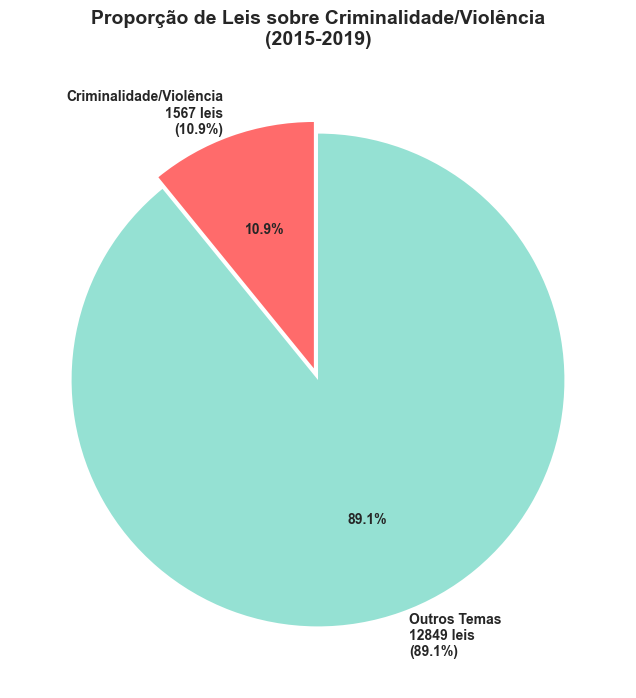

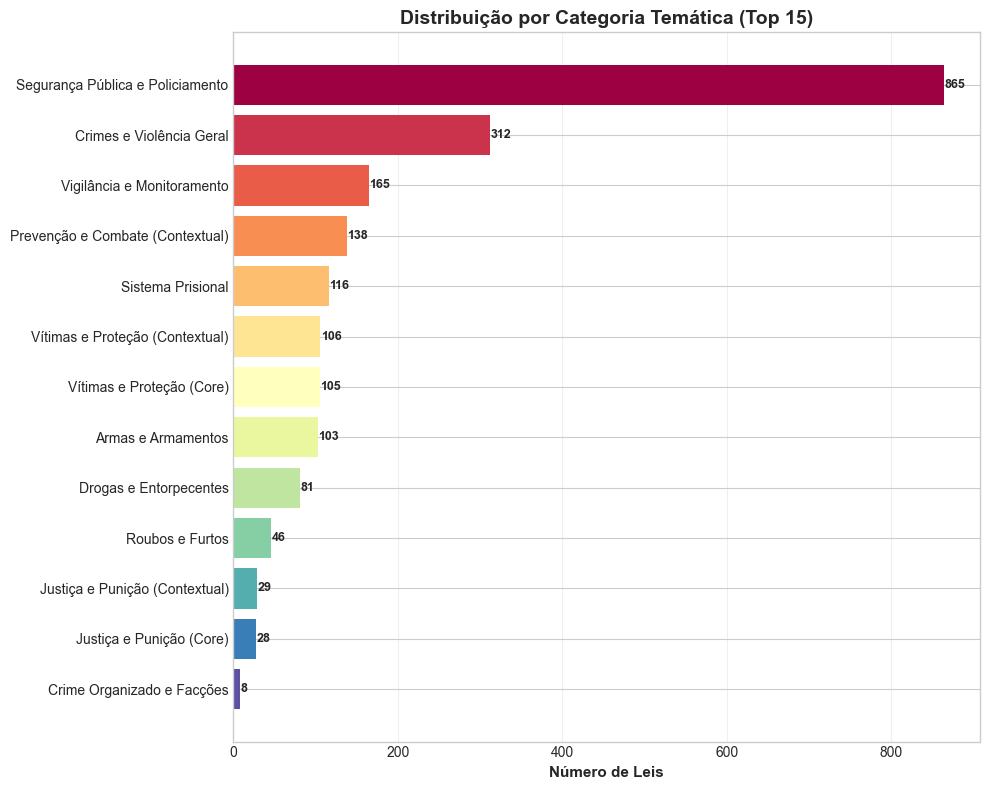

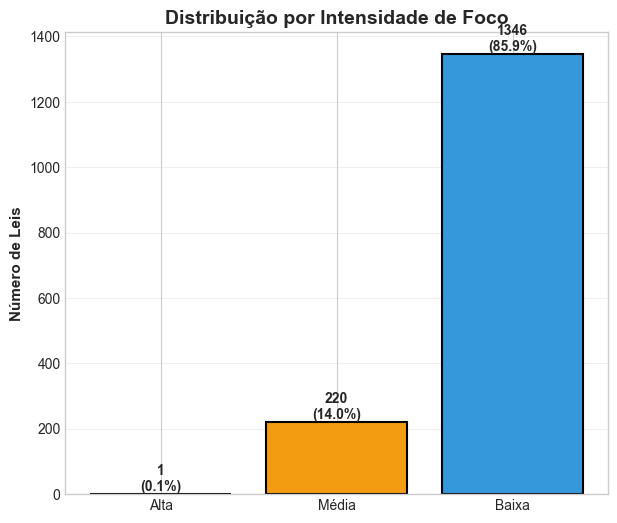

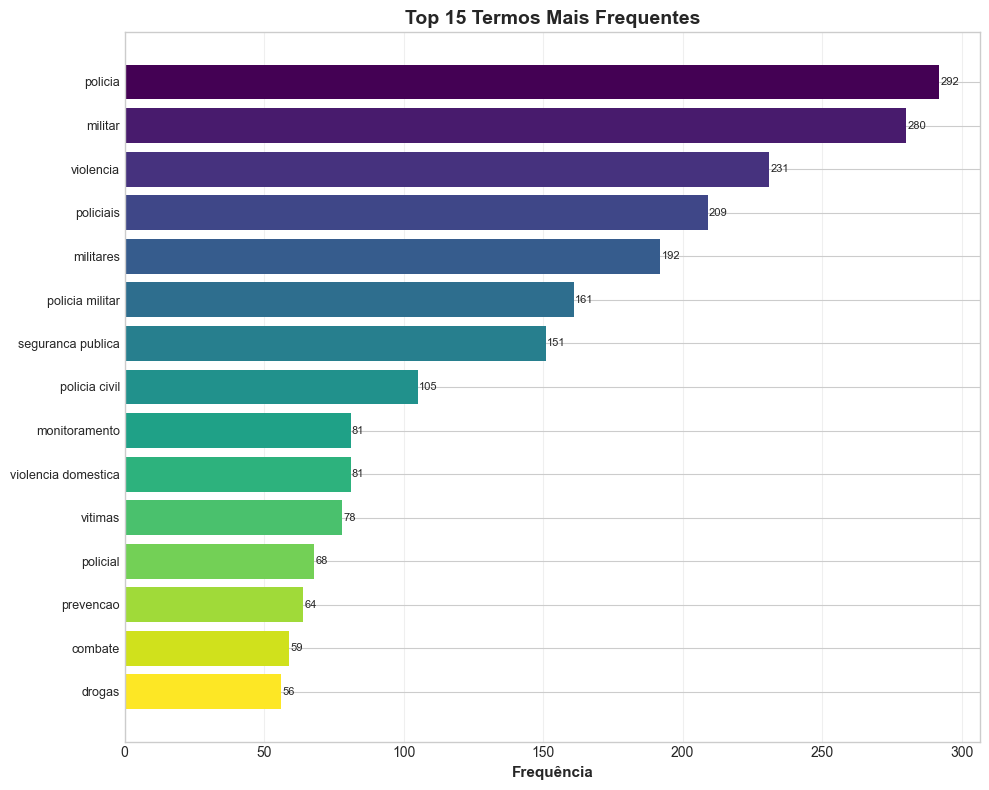

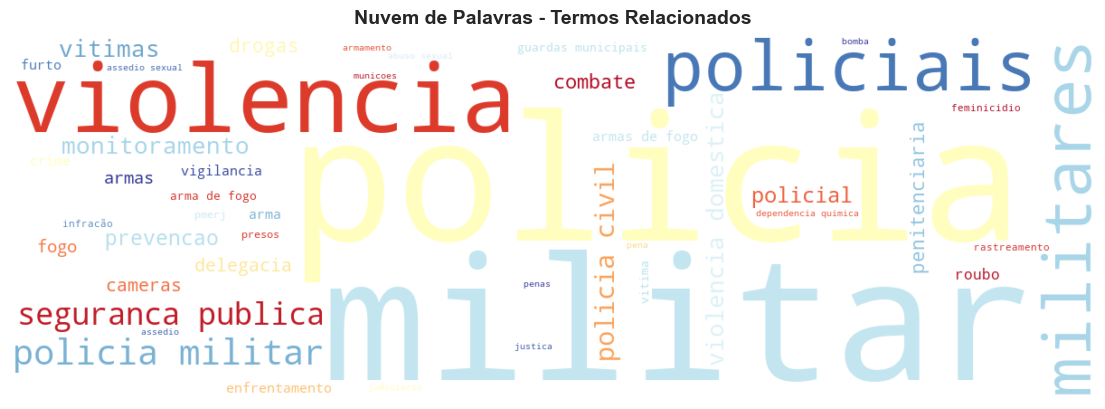

In [5]:
from collections import defaultdict, Counter
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# 1. DICIONÁRIOS TEMÁTICOS (REFINADOS)

# 1.1. DICIONARIO_CORE
DICIONARIO_CORE = {
    'crimes_violencia': ['crime', 'criminal', 'criminoso', 'criminalidade', 'criminosa', 'violencia', 'violento', 'violenta', 'delito', 'infracão', 'ilicito', 'ilegal', 'vandalismo', 'depredacao', 'homicidio', 'assassinato', 'latrocinio', 'feminicidio', 'agressao', 'lesao corporal', 'violencia fisica'],
    'crime_organizado': ['organizacao criminosa', 'crime organizado', 'organizacoes criminosas', 'faccao', 'faccoes', 'quadrilha', 'bando', 'gang', 'gangue', 'milicia', 'milicias', 'miliciano', 'milicianos', 'trafico', 'traficante', 'traficantes', 'narcotraficante', 'cartel', 'mafia', 'comando vermelho', 'terceiro comando', 'tcp', 'cv', 'acp'],
    'armas': ['arma', 'armas', 'armamento', 'armamentos', 'arma de fogo', 'armas de fogo', 'fogo', 'fuzil', 'fuzis', 'pistola', 'revolver', 'rifle', 'municao', 'municoes', 'bala', 'balas', 'projetil', 'explosivo', 'explosivos', 'bomba', 'granada', 'porte de arma', 'posse de arma', 'comercio de armas', 'armamento belico', 'arsenal', 'desarmamento', 'desarmar'],
    'drogas': ['droga', 'drogas', 'entorpecente', 'entorpecentes', 'narcotico', 'narcoticos', 'substancia ilicita', 'cocaina', 'crack', 'maconha', 'cannabis', 'dependencia quimica', 'dependente quimico', 'combate as drogas', 'prevencao drogas'],
    'roubos_furtos': ['roubo', 'roubos', 'assalto', 'assaltos', 'furto', 'furtos', 'latrocinio', 'extorsao', 'sequestro', 'carcere privado', 'estelionato', 'fraude'],
    'seguranca_publica': ['seguranca publica', 'seguranca urbana', 'policia', 'policial', 'policiais', 'policiamento', 'militar', 'militares', 'pm', 'pmerj', 'policia civil', 'policia militar', 'delegacia', 'delegado', 'guarda municipal', 'guardas municipais', 'operacao policial', 'abordagem policial', 'forca nacional', 'exercito'],
    'prisional': ['presidio', 'presidios', 'prisao', 'prisoes', 'cadeia', 'cadeias', 'penitenciaria', 'penitenciarias', 'detento', 'detentos', 'preso', 'presos', 'carcere', 'carceraria', 'carcerario', 'reintegracao', 'ressocializacao', 'regime fechado', 'regime semiaberto'],
    'vigilancia_monitoramento': ['camera', 'cameras', 'cftv', 'videomonitoramento', 'vigilancia', 'monitoramento', 'alarme', 'alarmes', 'cerca eletrica', 'seguranca eletronica', 'rastreamento', 'gps'],
    'vitimas_protecao_core': ['violencia domestica', 'violencia mulher', 'abuso sexual', 'estupro', 'assedio sexual'], # 'Assédio' sozinho é ambíguo, 'assedio sexual' não
    'justica_punicao_core': ['pena', 'penas', 'punir', 'condenacao', 'condena', 'sentenca', 'reclusao', 'detencao'], # Termos inequivocamente penais
}

# 1.2. DICIONARIO_CONTEXTUAL
DICIONARIO_CONTEXTUAL = {
    'prevencao_combate': ['prevencao', 'prevenir', 'preventivo', 'combate', 'combater', 'enfrentamento', 'reducao criminalidade', 'controle criminalidade', 'ostensivo', 'repressao', 'reprimir'],
    'justica_punicao_contextual': ['punicao', 'tribunal', 'judiciario', 'justica', 'penalidade', 'sancao', 'multa'], # 'multa' e 'sancao' estão aqui
    'vitimas_protecao_contextual': ['vitima', 'vitimas', 'vitimizacao', 'revitimizacao', 'protecao testemunha', 'protecao vitima', 'assedio'], # 'assedio' (geral) e 'vitima' (geral)
}

# 1.3. DICIONÁRIOS DE CONTEXTO (Refinamento)
EXCLUSOES_HARD = [
    'crime de responsabilidade', 'crime eleitoral', 'crime ambiental',
    'abuso de autoridade', 'abuso do poder economico',
    'estatuto do servidor', 'plano de carreira', 'concurso publico',
    'orcamentarias', 'diretrizes orcamentarias',
    'assedio moral' # Exclusão específica para evitar 'assedio' contextual
]

BOOSTERS = [
    'combate ao', 'combate a', 'prevencao ao', 'prevencao a',
    'enfrentamento ao', 'enfrentamento a', 'reducao do', 'reducao da'
]

# 1.4. PESOS E NOMES (AGREGADOS)
PESOS_CATEGORIA = {
    # Core
    'crime_organizado': 3.0, 'armas': 2.5, 'crimes_violencia': 2.0, 'drogas': 2.0,
    'roubos_furtos': 1.5, 'prisional': 1.5, 'seguranca_publica': 1.0,
    'vigilancia_monitoramento': 1.0, 'vitimas_protecao_core': 2.0, 'justica_punicao_core': 1.5,
    # Contextual
    'prevencao_combate': 1.2, 'justica_punicao_contextual': 0.8, 'vitimas_protecao_contextual': 1.0,
}

nomes_categorias = {
    'crimes_violencia': 'Crimes e Violência Geral',
    'crime_organizado': 'Crime Organizado e Facções',
    'armas': 'Armas e Armamentos',
    'drogas': 'Drogas e Entorpecentes',
    'roubos_furtos': 'Roubos e Furtos',
    'seguranca_publica': 'Segurança Pública e Policiamento',
    'prisional': 'Sistema Prisional',
    'vigilancia_monitoramento': 'Vigilância e Monitoramento',
    'justica_punicao_core': 'Justiça e Punição (Core)',
    'vitimas_protecao_core': 'Vítimas e Proteção (Core)',
    'prevencao_combate': 'Prevenção e Combate (Contextual)',
    'justica_punicao_contextual': 'Justiça e Punição (Contextual)',
    'vitimas_protecao_contextual': 'Vítimas e Proteção (Contextual)',
}

# 2. FUNÇÕES DE PROCESSAMENTO

def normalizar_texto(texto):
    if pd.isna(texto): return ""
    texto = texto.lower()
    substituicoes = {
        'á': 'a', 'à': 'a', 'ã': 'a', 'â': 'a', 'ä': 'a',
        'é': 'e', 'è': 'e', 'ê': 'e', 'ë': 'e',
        'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
        'ó': 'o', 'ò': 'o', 'õ': 'o', 'ô': 'o', 'ö': 'o',
        'ú': 'u', 'ù': 'u', 'û': 'u', 'ü': 'u',
        'ç': 'c', 'ñ': 'n'
    }
    for original, substituto in substituicoes.items():
        texto = texto.replace(original, substituto)
    return texto

def _buscar_termos_no_texto(texto_norm, dicionario, pesos):
    """Função auxiliar para buscar termos de um dicionário específico."""
    score = 0
    detalhes = defaultdict(list)
    palavras_encontradas = []

    for categoria, palavras in dicionario.items():
        peso = pesos.get(categoria, 1.0)
        
        for palavra in palavras:
            palavra_norm = normalizar_texto(palavra)
            
            if len(palavra_norm.split()) == 1:
                pattern = r'\b' + re.escape(palavra_norm) + r'\b'
            else:
                pattern = re.escape(palavra_norm)
            
            matches = len(re.findall(pattern, texto_norm))
            
            if matches > 0:
                score += matches * peso
                detalhes[categoria].append((palavra, matches))
                palavras_encontradas.append(palavra)
    
    return score, detalhes, palavras_encontradas

def analise_semantica_robusta(texto_norm, dic_core, dic_contextual, pesos, exclusoes, boosters):
    """
    Calcula score de relevância em dois passos:
    1. Busca termos CORE.
    2. Se encontrar, busca termos CONTEXTUAIS.
    """
    if not texto_norm:
        return 0, {}, False
    
    # 1. Checagem de Exclusão (Hard)
    for termo_ex in exclusoes:
        termo_norm = normalizar_texto(termo_ex)
        if re.search(re.escape(termo_norm), texto_norm):
            return 0, {}, False

    # 2. Passo 1: Buscar Termos CORE
    score_core, detalhes_core, palavras_core = _buscar_termos_no_texto(
        texto_norm, dic_core, pesos
    )

    # Se não houver termos CORE, a ementa não é relevante.
    if score_core == 0:
        return 0, {}, False
    
    # 3. Passo 2: Buscar Termos CONTEXTUAIS
    score_contextual, detalhes_contextual, palavras_contextual = _buscar_termos_no_texto(
        texto_norm, dic_contextual, pesos
    )

    # 4. Combinar Resultados
    score_total = score_core + score_contextual
    
    # Merge de detalhes e palavras
    detalhes_total = defaultdict(list, detalhes_core)
    for categoria, items in detalhes_contextual.items():
        detalhes_total[categoria].extend(items)
        
    palavras_total = list(set(palavras_core + palavras_contextual))

    # 5. Aplicação de Boosters
    boost_factor = 1.0
    for termo_boost in boosters:
        termo_norm = normalizar_texto(termo_boost)
        if re.search(re.escape(termo_norm), texto_norm):
            boost_factor = 1.5 # Aumenta o score em 50%
            break
            
    score_total *= boost_factor
    
    return score_total, dict(detalhes_total), palavras_total

# 3. ANÁLISE PRINCIPAL

print("ANÁLISE: LEGISLAÇÃO SOBRE CRIMINALIDADE E VIOLÊNCIA")
print("ALERJ - Leis Ordinárias 2011-2024")

df['texto_normalizado'] = df['ementa'].apply(normalizar_texto)

# Aplicar a nova função de análise robusta
resultados = df['texto_normalizado'].apply(
    lambda x: analise_semantica_robusta(
        x, DICIONARIO_CORE, DICIONARIO_CONTEXTUAL, 
        PESOS_CATEGORIA, EXCLUSOES_HARD, BOOSTERS
    )
)
df['score_relevancia'], df['detalhes_categorias'], df['palavras_encontradas'] = zip(*resultados)

df['relevante'] = df['score_relevancia'] > 0
df_relevantes = df[df['relevante']].copy()
df_relevantes = df_relevantes.sort_values('score_relevancia', ascending=False)

# 4. CÁLCULOS PARA RELATÓRIOS

total_leis = len(df)
leis_relevantes = len(df_relevantes)
percentual = 0
if total_leis > 0:
    percentual = (leis_relevantes / total_leis) * 100

# Cálculo de Categorias
categorias_count = defaultdict(int)
for idx, row in df_relevantes.iterrows():
    for categoria in row['detalhes_categorias'].keys():
        categorias_count[categoria] += 1
categorias_ordenadas = sorted(categorias_count.items(), key=lambda x: x[1], reverse=True)
df_categorias = pd.DataFrame(categorias_ordenadas, columns=['categoria_id', 'contagem'])
df_categorias['categoria_nome'] = df_categorias['categoria_id'].map(nomes_categorias).fillna(df_categorias['categoria_id'])
if leis_relevantes > 0:
    df_categorias['percentual'] = (df_categorias['contagem'] / leis_relevantes) * 100
else:
    df_categorias['percentual'] = 0

# Cálculo de Intensidade
df_relevantes['intensidade'] = pd.cut(
    df_relevantes['score_relevancia'],
    bins=[0, 5, 15, float('inf')],
    labels=['Baixa', 'Média', 'Alta'],
    right=False
)
intensidade_counts = df_relevantes['intensidade'].value_counts().reindex(['Alta', 'Média', 'Baixa']).fillna(0)

# Cálculo de Termos
todos_termos = []
for palavras in df_relevantes['palavras_encontradas']:
    todos_termos.extend(palavras)
freq_termos = Counter(todos_termos)
top_30_termos = freq_termos.most_common(30)

# 5. VISUALIZAÇÕES INDIVIDUAIS (MATPLOTLIB)

if leis_relevantes > 0:
    # 1. Pizza - Proporção geral
    plt.figure(figsize=(8, 8))
    sizes = [leis_relevantes, total_leis - leis_relevantes]
    labels = [f'Criminalidade/Violência\n{leis_relevantes} leis\n({percentual:.1f}%)',
              f'Outros Temas\n{total_leis - leis_relevantes} leis\n({100-percentual:.1f}%)']
    colors = ['#ff6b6b', '#95e1d3']
    explode = (0.05, 0)
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=explode, textprops={'fontsize': 10, 'weight': 'bold'})
    plt.title('Proporção de Leis sobre Criminalidade/Violência\n(2015-2019)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.show()

    # 2. Barras horizontais - Categorias
    plt.figure(figsize=(10, 8))
    cats_plot = categorias_ordenadas[:15]
    cats_labels = [nomes_categorias.get(c, c) for c, _ in cats_plot]
    cats_values = [v for _, v in cats_plot]
    
    bars = plt.barh(range(len(cats_labels)), cats_values, 
                    color=plt.cm.Spectral(np.linspace(0, 1, len(cats_labels))))
    plt.yticks(range(len(cats_labels)), cats_labels, fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('Número de Leis', fontsize=11, fontweight='bold')
    plt.title('Distribuição por Categoria Temática (Top 15)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, cats_values)):
        plt.text(val + 0.5, i, str(val), va='center', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 3. Barras - Intensidade
    plt.figure(figsize=(7, 6))
    colors_int = ['#e74c3c', '#f39c12', '#3498db']
    bars_int = plt.bar(intensidade_counts.index, intensidade_counts.values, 
                         color=colors_int, edgecolor='black', linewidth=1.5)
    plt.ylabel('Número de Leis', fontsize=11, fontweight='bold')
    plt.title('Distribuição por Intensidade de Foco', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars_int, intensidade_counts.values):
        height = bar.get_height()
        if val > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(val)}\n({val/leis_relevantes*100:.1f}%)',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.show()

    # 4. Top termos - Barras horizontais
    plt.figure(figsize=(10, 8))
    top_15_termos = freq_termos.most_common(15)
    termos_labels = [t for t, _ in top_15_termos]
    termos_values = [v for _, v in top_15_termos]

    bars_termos = plt.barh(range(len(termos_labels)), termos_values, 
                           color=plt.cm.viridis(np.linspace(0, 1, len(termos_labels))))
    plt.yticks(range(len(termos_labels)), termos_labels, fontsize=9)
    plt.gca().invert_yaxis()
    plt.xlabel('Frequência', fontsize=11, fontweight='bold')
    plt.title('Top 15 Termos Mais Frequentes', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars_termos, termos_values)):
        plt.text(val + 0.5, i, str(val), va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

    # 5. Nuvem de palavras
    plt.figure(figsize=(14, 7))
    wordcloud = WordCloud(
        width=1200, 
        height=400,
        background_color='white',
        colormap='RdYlBu_r',
        max_words=80,
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(freq_termos)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras - Termos Relacionados', 
              fontsize=14, fontweight='bold', pad=10)
    plt.show()

else:
    print("\nNenhuma lei relevante encontrada. Gráficos não podem ser gerados.")